In [ ]:
import os
import time
from copy import copy
from pathlib import Path
from joblib import Memory
from scipy import sparse
from scipy.sparse import csc_matrix
from scipy.special import expit
from scipy.stats import pearsonr
import scikitplot as skplt
import shap

from sklearn import svm
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample, shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, normalize
from sklearn import metrics
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from category_encoders import TargetEncoder

import pyarrow.feather as feather
import matplotlib.pyplot as plt
import plotnine as p9
import pandas as pd
import numpy as np

rand_state = 5991

# Paths
idcsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/scripts/here_we_are/id_csc.feather"
tarcsc = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/scripts/here_we_are/tarcsc.feather"
fulldf = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/scripts/here_we_are/full_df.feather"

my_filesys_pth = "C:/Code/GITHUB/csc/Classification-of-Pell-Institutions/"

# REGRESSION PROJECT IS ASKING THE QUESTION: 
#       Can I predict the number of students 
#           that are receiving a Pell grant 
#           from the student demographic 
#           profile of an institution?

In [ ]:
# FUNCTIONS
def split_data(xx, yy, testsize = 1000):
    xtrain, xtest, y_train, y_test = train_test_split(xx,
                                                      yy,
                                                      test_size = testsize,
                                                      random_state = rand_state)
    xtrain, xvalid, y_train, y_valid = train_test_split(xtrain, y_train, 
                                                        test_size = testsize,
                                                        random_state = rand_state)
    y_train = np.array(y_train).reshape(-1, 1)
    y_test = np.array(y_test).reshape(-1, 1)
    y_valid = np.array(y_valid).reshape(-1, 1)

    print(" SHAPE of xtrain:", xtrain.shape)
    print("SHAPE of y_train:", y_train.shape)
    print("  SHAPE of xtest:", xtest.shape)
    print(" SHAPE of y_test:", y_test.shape)
    print(" SHAPE of xvalid:", xvalid.shape)
    print("SHAPE of y_valid:", y_valid.shape)

    return xtrain, y_train, xtest, y_test, xvalid, y_valid 

def get_acc_auc(y, p):
    acc = np.sum(y == p) / len(y)
    auc = roc_auc_score(y, p)
    return acc, auc

def get_outs(model, train, test, valid, ytrain, ytest, yvalid):
    train_acc = round(model.score(train, ytrain), 4)
    test_acc = round(model.score(test, ytest), 4)
    valid_acc = round(model.score(valid, yvalid), 4)

    train_auc = round(roc_auc_score(ytrain, model.predict_proba(train)[:,1]), 4)
    test_auc = round(roc_auc_score(ytest, model.predict_proba(test)[:,1]), 4)
    valid_auc = round(roc_auc_score(yvalid, model.predict_proba(valid)[:,1]), 4)

    return train_auc, test_auc, valid_auc, train_acc, test_acc, valid_acc  

In [295]:
id_csc = feather.read_feather(idcsc)
tar_csc = feather.read_feather(tarcsc)
full_df = feather.read_feather(fulldf)

missing = pd.DataFrame(full_df.isna().sum())
missing.reset_index(inplace=True)
missing[missing[0] > 0]

# Do the ids column in the target frame match the the ids column in the full frame for each unique UNITID?
# df = pd.merge(tar_csc[["ids", "UNITID"]],
#          full_df[["ids", "UNITID"]],
#          how = "left", left_on = "UNITID", right_on = "UNITID",
#          suffixes=("_target", "_full"))
# df["diff"] = df["ids_target"] - df["ids_full"]
# df.loc[df["diff"] > 0 ]
# # Yes
# tar_csc["PELLCAT"] = abs(1 - tar_csc["PELLCAT"])

df1 = id_csc.query("INSTNM == 'Kennesaw State University'")
df1["UNITID"] = "486840"

df2 = full_df.iloc[5587:5588]
df2["UNITID"] = "486840"

KSU_data = pd.merge(df1, df2, how = "left",
         left_on = "UNITID", right_on = "UNITID")

tar_csc
KSU_data

C:\Users\Nate\AppData\Local\Temp/ipykernel_14484/3744279245.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Nate\AppData\Local\Temp/ipykernel_14484/3744279245.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,UNITID,FEDSCHCD,OPEID,OPEID6,INSTNM,PELLCAT,PCTPELL,ids,ST_FIPS,CITY Encoded,...,LPSTAFFORD_CNT,LPPPLUS_AMT,DBRR1_FED_UGCOMP_DEN,DBRR4_FED_UGCOMP_RT,DBRR1_PP_UG_NUM,OMAWDP8_FULLTIME,OMENRAP_FULLTIME,OMACHT8_FTFT,OMENRYP_FULLTIME,OMAWDP8_FTFT
0,486840,1577,157700.0,1577.0,Kennesaw State University,0.0,0.3689,5587,13,0.636753,...,86233.0,124948445.0,133080317.0,0.954658,25211894.0,0.5214,0.2793,3819.0,0.022,0.4658


In [ ]:
# from sklearn.feature_selection import VarianceThreshold
# dffff = full_df.drop(["ids", "UNITID", "FTFTPCTPELL", "ST_FIPS", "LOCALE_31"], axis = 1)
# print(dffff.shape)

# select = VarianceThreshold(threshold = 0.21)
# select.fit(dffff)
# const_columns = [column for column in dffff.columns if column not in dffff.columns[select.get_support()]]
# print(len(const_columns))

In [304]:
ys = tar_csc["PELLCAT"].copy()
full_df["ST_FIPS"] = full_df["ST_FIPS"].astype(int)
xs = full_df.drop(["ids", "UNITID", "FTFTPCTPELL", "ST_FIPS", "LOCALE_31", "LPPPLUS_AMT", "LPSTAFFORD_CNT"], axis = 1).copy()
print("SHAPE of xs:", xs.shape)
print("SHAPE of ys:", ys.shape)
xtrain, y_train, xtest, y_test, xvalid, y_valid = split_data(xs, ys, testsize = 1000)
print(xtrain.shape)


SHAPE of xs: (5879, 222)
SHAPE of ys: (5879,)
 SHAPE of xtrain: (3879, 222)
SHAPE of y_train: (3879, 1)
  SHAPE of xtest: (1000, 222)
 SHAPE of y_test: (1000, 1)
 SHAPE of xvalid: (1000, 222)
SHAPE of y_valid: (1000, 1)
(3879, 222)


In [306]:
# from sklearn.feature_selection import VarianceThreshold
# dffff = xtrain  #.drop(["ids", "UNITID", "FTFTPCTPELL", "ST_FIPS", "LOCALE_31"], axis = 1)
# print(dffff.shape)
# th = [0.001, 0.002, 0.03, 0.004, 0.05, 0.06]

# # for t in th:
# select = VarianceThreshold(threshold = 0.03)
# select.fit(dffff)
# const_columns = [column for column in dffff.columns if column not in dffff.columns[select.get_support()]]
# print(len(const_columns))

# xtrain = xtrain.drop(const_columns, axis = 1)

In [305]:
xnot =  list(xtrain.columns[xtrain.columns.str.startswith("PELL")])
print("variables to be removed:")
print(len(xnot))
print("remaining variables:")

features = xtrain.columns
features2 = xtrain.columns.drop(xnot)

print(len(features2))

variables to be removed:
2
remaining variables:
220


### Feature Scaling

In [307]:
scaler = StandardScaler()
poly = PolynomialFeatures(3)

scaler.fit(xtrain[features])
xtrain2 = pd.DataFrame(scaler.transform(xtrain[features]), columns = features)
xvalid2 = pd.DataFrame(scaler.transform(xvalid[features]), columns = features)
xtest2 = pd.DataFrame(scaler.transform(xtest[features]), columns = features)

scaler.fit(xtrain[features2])
xtrain3 = pd.DataFrame(scaler.transform(xtrain[features2]), columns = features2)
xvalid3 = pd.DataFrame(scaler.transform(xvalid[features2]), columns = features2)
xtest3 = pd.DataFrame(scaler.transform(xtest[features2]), columns = features2)

print("      ORIGINAL -  xtrain before:", xtrain.shape)
print("        SCALED - xtrain2 before:", xtrain2.shape)
print("SCALED&REDUCED - xtrain3 before:", xtrain3.shape)

      ORIGINAL -  xtrain before: (3879, 222)
        SCALED - xtrain2 before: (3879, 222)
SCALED&REDUCED - xtrain3 before: (3879, 220)


### Checking for correlation between feature pairings

In [308]:
scaler = StandardScaler()
poly = PolynomialFeatures(3)

scaler.fit(xtrain[features])
xtrain2 = pd.DataFrame(scaler.transform(xtrain[features]), columns = features)
xvalid2 = pd.DataFrame(scaler.transform(xvalid[features]), columns = features)
xtest2 = pd.DataFrame(scaler.transform(xtest[features]), columns = features)

scaler.fit(xtrain[features2])
xtrain3 = pd.DataFrame(scaler.transform(xtrain[features2]), columns = features2)
xvalid3 = pd.DataFrame(scaler.transform(xvalid[features2]), columns = features2)
xtest3 = pd.DataFrame(scaler.transform(xtest[features2]), columns = features2)

print("      ORIGINAL -  xtrain before:", xtrain.shape)
print("        SCALED - xtrain2 before:", xtrain2.shape)
print("SCALED&REDUCED - xtrain3 before:", xtrain3.shape)

      ORIGINAL -  xtrain before: (3879, 222)
        SCALED - xtrain2 before: (3879, 222)
SCALED&REDUCED - xtrain3 before: (3879, 220)


In [ ]:
# SCALED AND REDUCED DATASET
corrs = []
contFeat = list(xtrain3.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = xtrain3[contFeat[i]].values.flatten()
        featj = xtrain3[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
grb = correl.groupby(["feat1", "feat2"]).count()
grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(xtrain3.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")

### Feature transformation

In [309]:
# CREDIT: Dr. Vanderheyden wrote this code.
accuracies = []
for f in features2:
    log_reg = LogisticRegression(solver = "saga",
                                 random_state = rand_state,
                                 penalty = "l1",
                                 class_weight = "balanced",
                                 max_iter = 1000)
    x = xtrain3[f].values.reshape(-1, 1)
    y = y_train.reshape(-1, 1)
    ## LIN ##############################
    log_reg.fit(x, y)
    acc, auc = get_acc_auc(y, log_reg.predict(x))
    ## LOG #############################   
    xl = np.log(x - np.min(x) + 1)
    log_reg.fit(xl, y)
    lcc, luc = get_acc_auc(y, log_reg.predict(xl))

    if lcc / acc >= 1.1 or luc / auc >= 1.05:  # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_log"] = xl
        xvalid3[f + "_log"] = np.log(xvalid3[f].values.reshape(-1, 1) - np.min(xtrain3[f])+1)
        xtest3[f + "_log"] = np.log(xtest3[f].values.reshape(-1, 1) - np.min(xtrain3[f])+1)
    ## EXP #############################   
    xe = np.exp(x)
    log_reg.fit(xe, y)
    ecc, euc = get_acc_auc(y, log_reg.predict(xe))

    # if ecc / acc >= 1.1 or euc / auc >= 1.05: 
    #     xtrain3[f + "_exp"] = xe
    #     xvalid3[f + "_exp"] = np.exp(xvalid3[f].values.reshape(-1, 1))
    #     xtest3[f + "_exp"] = np.exp(xtest3[f].values.reshape(-1, 1))
    ## POLY ############################# 
    poly.fit(x)
    xp = poly.transform(x)
    log_reg.fit(xp, y)
    pcc, puc = get_acc_auc(y, log_reg.predict(xp))
    # if pcc / acc >= 1.1 or puc / auc >= 1.05:  # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
    #     xtrain3[f + "_p2"] = x**2
    #     xtrain3[f + "_p3"] = x**3
    #     xvalid3[f + "_p2"] = (xvalid3[f].values)**2
    #     xvalid3[f + "_p3"] = (xvalid3[f].values)**3
    #     xtest3[f + "_p2"] = (xtest3[f].values)**2
    #     xtest3[f + "_p3"] = (xtest3[f].values)**3
    ## BIN #############################
    xmin = x.min()
    rnge = x.max() - xmin

    xtrn = 0 + ((x - xmin) > 1 * rnge / 10) + ((x - xmin) > 2 * rnge / 10) + ((x - xmin) > 3 * rnge / 10) + ( # the objects in each
                (x - xmin) > 4 * rnge / 10) + ((x - xmin) > 5 * rnge / 10) + ((x - xmin) > 6 * rnge / 10) + ( # bracket returns true
                (x - xmin) > 7 * rnge / 10) + ((x - xmin) > 8 * rnge / 10) + ((x - xmin) > 9 * rnge / 10)     # or false 
    xval = 0 + ((xvalid3[f] - xmin) > 1 * rnge / 10) + ((xvalid3[f] - xmin) > 2 * rnge / 10) + ((xvalid3[f] - xmin) > 3 * rnge / 10) + (
                (xvalid3[f] - xmin) > 4 * rnge / 10) + ((xvalid3[f] - xmin) > 5 * rnge / 10) + ((xvalid3[f] - xmin) > 6 * rnge / 10) + (
                (xvalid3[f] - xmin) > 7 * rnge / 10) + ((xvalid3[f] - xmin) > 8 * rnge / 10) + ((xvalid3[f] - xmin) > 9 * rnge / 10)
    xtst = 0 + ((xtest3[f] - xmin) > 1 * rnge / 10) + ((xtest3[f] - xmin) > 2 * rnge / 10) + ((xtest3[f] - xmin) > 5 * rnge / 10) + (
                (xtest3[f] - xmin) > 3 * rnge / 10) + ((xtest3[f] - xmin) > 4 * rnge / 10) + ((xtest3[f] - xmin) > 6 * rnge / 10) + (
                (xtest3[f] - xmin) > 7 * rnge / 10) + ((xtest3[f] - xmin) > 8 * rnge / 10) + ((xtest3[f] - xmin) > 9 * rnge / 10)
                
    encoder = TargetEncoder()

    encoder.fit(xtrn, y)
    xb = encoder.transform(xtrn)
    log_reg.fit(xb, y)

    bcc, buc = get_acc_auc(y, log_reg.predict(xb))

    if bcc / acc >= 1.1 or buc / auc >= 1.05: # if bin accuracy is 110% of linear accuracy or ... AUC is 105% ...
        xtrain3[f + "_Bin"] = xb
        xvalid3[f + "_Bin"] = encoder.transform(xval)
        xtest3[f + "_Bin"] = encoder.transform(xtst)
    ## COMPLETION #############################
    lDa = lcc / acc
    eDa = ecc / acc
    pDa = pcc / acc
    bDa = bcc / acc
    lda = luc / auc
    eda = euc / auc
    pda = puc / auc
    bda = buc / auc
    accuracies.append([f, acc, lcc, ecc, pcc, bcc, auc, luc, euc, puc, buc, lDa, eDa, pDa, bDa, lda, eda, pda, bda])
###############################################

colums = ["Feature","ACC: Linear", "ACC: Log", "ACC: Exp", "ACC: Poly3","ACC: Bin",
                    "AUC: Simple Linear", "AUC: Log", "AUC: Exp","AUC: Poly3", "AUC: Bin",
                    "ACC: LOG / Linear", "ACC: EXP / Linear", "ACC: Poly3 / Linear", "ACC: Bin / Linear",
                    "AUC: LOG / Linear", "AUC: EXP / Linear", "AUC: Poly3 / Linear", "AUC: Bin / Linear"]
accDf = pd.DataFrame(accuracies, columns = colums)

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
C:\Users\Nate\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataCo

In [310]:
print(xtrain3.shape)
accDf.to_csv("acc_df.csv")
accDf.loc[:, ["Feature", "ACC: LOG / Linear", "ACC: EXP / Linear", "ACC: Poly3 / Linear", "ACC: Bin / Linear",
                         "AUC: LOG / Linear", "AUC: EXP / Linear", "AUC: Poly3 / Linear", "AUC: Bin / Linear"]
             ].sort_values("ACC: LOG / Linear", ascending = False).head(5)

(3879, 244)


,Feature,ACC: LOG / Linear,ACC: EXP / Linear,ACC: Poly3 / Linear,ACC: Bin / Linear,AUC: LOG / Linear,AUC: EXP / Linear,AUC: Poly3 / Linear,AUC: Bin / Linear
102,HIGHDEG_3,1.409317,1.048329,1.048329,1.000000,1.000000,1.000101,1.000101,1.000000
158,FIRSTGEN_DEBT_N,1.306961,1.409317,1.349170,1.388213,0.998297,1.000000,0.988764,1.023349
162,FEMALE_DEBT_N,1.217998,1.310318,1.252336,1.290598,0.986553,0.993481,0.997386,1.014130
219,OMAWDP8_FTFT,1.150682,0.969468,0.984922,0.988409,0.744046,0.958160,0.943819,0.980149
183,NPT41_PRIV,1.150013,1.259293,1.083822,1.178771,1.383212,1.130079,1.485967,1.237527


In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

ddrp_lst = [ 'GRAD_DEBT_MDN10YR'] #, 'TUITIONFEE_OUT_p2'] # ,'TUITIONFEE_IN_exp', 'TUITIONFEE_IN_p3', 'TUITIONFEE_OUT_p3', 'MALE_DEBT_MDN_p3', 

mutual_info = mutual_info_classif(xtrain3.drop(ddrp_lst, axis = 1), y_train)

print(xtrain3.drop(ddrp_lst, axis = 1).shape)

sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain3.drop(ddrp_lst, axis = 1), y_train)
lst = sel_five_cols.get_support()
lst = xtrain3.drop(ddrp_lst, axis = 1).columns[lst]
# xtrain4[lst]
lst
x_train3 = xtrain3[lst]
x_test3 = xtest3[lst]
x_valid3 = xvalid3[lst]

#### Rechecking for correlation between feature pairings

In [ ]:
# SCALED AND REDUCED DATASET
corrs = []
contFeat = list(x_train3.columns)
contFeat_length = len(contFeat)

for i in range(contFeat_length):
    for j in range(i + 1, contFeat_length):
        feati = x_train3[contFeat[i]].values.flatten()
        featj = x_train3[contFeat[j]].values.flatten()

        corr, _ = pearsonr(feati, featj)
        corrs.append([corr, abs(corr), contFeat[i], contFeat[j]])
correl = pd.DataFrame(corrs, columns = ["P_Corr", "P_Corr_abs", "feat1", "feat2"])
################################
grb = correl.groupby(["feat1", "feat2"]).count()
grb.sort_values("P_Corr_abs", ascending=False).to_csv("xtrain1_corrgroups.csv")
################################
tot_var_pair = (contFeat_length * (contFeat_length - 1) / 2)
num_var_g50 = len(correl[abs(correl["P_Corr"]) > 0.5])
pct_var_g50 = np.round(num_var_g50 / tot_var_pair * 100, 4)
print(x_train3.shape)
print(int(tot_var_pair), " : Total number of features pairs:")
print(num_var_g50, "   : Number of features pairs with absolute Pearson Correl above 0.5:")
print(pct_var_g50, "% : Percent of features pairs with absolute Pearson Correl above 0.5:")
# correl.sort_values("P_Corr_abs", ascending=False).head(15)

## Modelling

#### PCA

In [ ]:
# import plotly.express as px
# from sklearn.decomposition import PCA

# df = xtrain
# features = xtrain.columns.values

# pca = PCA()
# components = pca.fit_transform(df[features])
# labels = {
#     str(i): f"PC {i+1} ({var:.1f}%)"
#     for i, var in enumerate(pca.explained_variance_ratio_ * 100)
# }

# fig = px.scatter_matrix(
#     components,
#     labels=labels,
#     dimensions=range(2),
#     color=y_train.reshape(-1,)
# )
# fig.update_traces(diagonal_visible=True)
# fig.show()

# from pca import pca
# xtrain_var = xtrain2.drop(["PELL_DEBT_MDN"], axis = 1)
# xtest_var = xtest2.drop(["PELL_DEBT_MDN"], axis = 1)
# xvalid_var = xvalid2.drop(["PELL_DEBT_MDN"], axis = 1)
# k = 22

# model = pca(n_components=k)

# results = model.fit_transform(xtrain_var)

# fig, ax = model.plot(n_components=50)
# # fig, ax = model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = False, PC = [10,3,7,1,6,5,4,2,8,9,0])#np.arange(0,k,1))
# fig, ax = model.biplot(y = y_train.reshape(-1,), n_feat=k, legend=True, cmap='PiYG', label = True, d3=True, figsize=(14, 14))
# import scikitplot as skplt


##### ORIG dataset

In [ ]:
# ORIG: xtrain FULL
%matplotlib inline

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 5,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:4].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(5) # LPPPLUS_AMT DBRR1_FED_UGCOMP_DEN

from pca import pca

model = pca(n_components=10, random_state = rand_state)
results = model.fit_transform(xtrain_var)

model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [2, 0])
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + 'images/ORIG/FULL/PCA/PCA_featureimportance.png')

In [ ]:
# ORIG: xtrain REDUC
ddrp_lst = ['GRAD_DEBT_MDN10YR',"NOPELL_DEBT_N", 'DBRR4_FED_UGCOMP_RT','FTFTPCTFLOAN']
mutual_info = mutual_info_classif(xtrain.drop(ddrp_lst, axis = 1), y_train, random_state = rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain.drop(ddrp_lst, axis = 1), y_train)
lst = sel_five_cols.get_support()
lst = xtrain.drop(ddrp_lst, axis = 1).columns[lst]
x_train = xtrain[lst]
x_test = xtest[lst]
x_valid = xvalid[lst]

x_t1_lst = lst.copy()

%matplotlib inline

xtrain_var = x_train
xtest_var = x_test
xvalid_var = x_valid

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 5,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:4].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_explainedvar.png')

interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10) # LPPPLUS_AMT DBRR1_FED_UGCOMP_DEN

In [ ]:
from pca import pca
model = pca(n_components=10, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 2])
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + 'images/ORIG/REDUC/PCA/PCA_featureimportance.png')

##### STAND dataset

In [ ]:
# STAND: xtrain2 FULL
file_specific_pth = "images/STAND/FULL/PCA/"

x_train2 = xtrain2
x_test2 = xtest2
x_valid2 = xvalid2

%matplotlib inline

xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 80,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

In [ ]:
from pca import pca

model = pca(n_components=80, random_state = rand_state)
results = model.fit_transform(xtrain_var)
# model.biplot(y = y_train.reshape(-1,), n_feat=3, legend=True, cmap='PiYG', label = False, d3=True, figsize=(14, 14))
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [7, 3])#np.arange(0,k,1)) 7 2
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=4) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

In [ ]:
# STAND: xtrain2 REDUC
file_specific_pth = "images/STAND/REDUC/PCA/"

mutual_info = mutual_info_classif(xtrain2.drop("GRAD_DEBT_MDN", axis = 1), y_train, random_state = rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain2, y_train)
lst = sel_five_cols.get_support()
lst = xtrain2.columns[lst]
x_train2 = xtrain2[lst]
x_test2 = xtest2[lst]
x_valid2 = xvalid2[lst]

x_t2_lst = lst.copy()

%matplotlib inline

xtrain_var = x_train2
xtest_var = x_test2
xvalid_var = x_valid2

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 10,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

In [ ]:
from pca import pca

model = pca(n_components=4, random_state = rand_state)
results = model.fit_transform(xtrain_var)
# model.biplot(y = y_train.reshape(-1,), n_feat=3, legend=True, cmap='PiYG', label = False, d3=True, figsize=(14, 14))
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 1])#np.arange(0,k,1)) 7 2
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=4) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

##### STAND&TRANS dataset

In [ ]:
# STAND&TRANS: xtrain3 FULL
file_specific_pth = "images/STAND_TRAN/FULL/PCA/"
# drrp = ["CCBASIC_31_exp", "CCUGPROF_8_exp", "OMENRYP_FULLTIME_exp", "OMACHT8_FTFT_exp", "OPEFLAG_3_exp", "CCBASIC_25_exp", "CCUGPROF_0_exp", "INEXPFTE_exp"]
%matplotlib inline

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

initial_feature_names = list(xtrain_var.columns)

pca = PCA(#n_components = 80,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:3].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable.sort_values([1], ascending = False).head(10)

In [ ]:
from pca import pca

model = pca(n_components=80, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [0, 3])
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=10) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

In [ ]:
# STAND&TRANS: xtrain3 REDUC
file_specific_pth = "images/STAND_TRAN/REDUC/PCA/"
ddrp_lst = ['GRAD_DEBT_MDN'] #,'TUITIONFEE_IN_exp', 'TUITIONFEE_IN_p3', 'TUITIONFEE_OUT_p3', 'MALE_DEBT_MDN_p3', 'TUITIONFEE_OUT_p2',"NOPELL_DEBT_N_exp", "AVGFACSAL_exp"]
mutual_info = mutual_info_classif(xtrain3.drop(ddrp_lst, axis = 1), y_train, random_state=rand_state)
sel_five_cols = SelectKBest(mutual_info_classif, k = 10)
sel_five_cols.fit(xtrain3.drop(ddrp_lst, axis = 1), y_train)
lst = sel_five_cols.get_support()
lst = xtrain3.drop(ddrp_lst, axis = 1).columns[lst]
x_train3 = xtrain3[lst]
x_test3 = xtest3[lst]
x_valid3 = xvalid3[lst]

x_t3_lst = lst

%matplotlib inline
k = 50

xtrain_var = x_train3
xtest_var = x_test3
xvalid_var = x_valid3
print(xtrain_var.shape)

initial_feature_names = list(xtrain_var.columns)

pca = PCA(n_components = 10,
          random_state = rand_state) #  
principalComponents = pca.fit_transform(xtrain_var)

most_important = [np.abs(pca.components_[i]).argmax() for i in range(pca.components_.shape[0])]
most_important_names = [initial_feature_names[most_important[i]] for i in range(pca.components_.shape[0])]

pc_df = pd.DataFrame(data = principalComponents,
                     columns = most_important_names)
df = pd.DataFrame({'var': pca.explained_variance_ratio_})
pca_df = pd.DataFrame(pca.fit_transform(xtrain_var),
                      columns = most_important_names)

print(df[0:2].sum())
sns.scatterplot(x=range(1, pca_df.shape[1]+1),y="var", data=df, color="c");

print('test average log-likelihood: ', pca.score(xtest_var))
print('validation average log-likelihood: ', pca.score(xvalid_var))
print('train average log-likelihood: ', pca.score(xtrain_var))

skplt.decomposition.plot_pca_component_variance(pca,
                            title='PCA Component Explained Variances of Program offerings',
                            target_explained_variance=0.8,
                            ax=None,
                            figsize=None,
                            title_fontsize='large',
                            text_fontsize='medium')
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_explainedvar.png')
interest_variable = pd.DataFrame([most_important_names,
                                  pca.explained_variance_ratio_]).T
interest_variable = interest_variable.sort_values([1], ascending = False)
interest_variable


In [ ]:
from pca import pca
model = pca(n_components=5, random_state = rand_state)
results = model.fit_transform(xtrain_var)
model.scatter(y = y_train.reshape(-1,), legend=True, cmap='Pastel2_r', label = True, PC = [1, 4])#np.arange(0,k,1)) 1 4    2  1     3 0
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_scatter.png')

model.plot(n_components=5) 
plt.savefig(my_filesys_pth + file_specific_pth + 'PCA_featureimportance.png')

#### Log Regression

In [ ]:
# OTHER Work
# xtrain_var = xtrain
# xtest_var = xtest
# xvalid_var = xvalid

# y_train_var = y_train
# y_test_var = y_test
# y_valid_var = y_valid

# ccc = [0.001]
# n_est = [90] # np.arange(10,100,10)# 
# penal = ["l1", "l2"]

# logReg_lst = []

# for cc in ccc:
#     for nest in n_est:
#         for p in penal:
#             logReg = LogisticRegression(solver = "saga",
#                                         random_state = rand_state, 
#                                         penalty = p, 
#                                         C = cc, 
#                                         class_weight = "balanced",
#                                         max_iter = nest)
#             logReg.fit(xtrain_var, y_train_var)

#             Tpred = logReg.predict(xtrain_var)
#             vpred = logReg.predict(xvalid_var)
#             tpred = logReg.predict(xtest_var)

#             Tprob = logReg.predict_proba(xtrain_var)
#             vprob = logReg.predict_proba(xvalid_var)
#             tprob = logReg.predict_proba(xtest_var)

#             logReg_lst.append(["saga", p, cc, nest, np.sum(logReg.coef_==0),
#                             round(roc_auc_score(y_train_var, Tprob[:,1]), 4), round(roc_auc_score(y_test_var, tprob[:,1]), 4), round(roc_auc_score(y_valid_var, vprob[:,1]), 4),
#                             round(1 - np.mean(abs(y_train_var - Tpred)), 4), round(1 - np.mean(abs(y_test_var - tpred)), 4), round(1 - np.mean(abs(y_valid_var- vpred)), 4),
#                             ])

# colums = ["solver", "penalty", "C", "max_iter", "coef_eq_zero",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           ]
# logReg_outcomes = pd.DataFrame(logReg_lst, columns = colums)

# # OTHER worrk
# xtrain_var = x_train2
# xtest_var = x_test2
# xvalid_var = x_valid2

# y_train_var = y_train
# y_test_var = y_test
# y_valid_var = y_valid

# ccc = [100, 10, 1.0, 0.1, 0.01]
# n_est = [10, 100, 500, 1000]
# penal = ["l1", "l2"]

# logReg_lst = []

# for cc in ccc:
#     for nest in n_est:
#         for p in penal:
#             logReg = LogisticRegression(solver = "saga",
#                                         random_state = rand_state, 
#                                         penalty = p, 
#                                         C = cc, 
#                                         class_weight = "balanced",
#                                         max_iter = nest)
#             logReg.fit(xtrain_var, y_train_var)

#             Tpred = logReg.predict(xtrain_var)
#             vpred = logReg.predict(xvalid_var)
#             tpred = logReg.predict(xtest_var)

#             Tprob = logReg.predict_proba(xtrain_var)
#             vprob = logReg.predict_proba(xvalid_var)
#             tprob = logReg.predict_proba(xtest_var)

#             logReg_lst.append(["saga", p, cc, nest, np.sum(logReg.coef_==0),
#                             round(roc_auc_score(y_train_var, Tprob[:,1]), 4), round(roc_auc_score(y_test_var, tprob[:,1]), 4), round(roc_auc_score(y_valid_var, vprob[:,1]), 4),
#                             round(1 - np.mean(abs(y_train_var - Tpred)), 4), round(1 - np.mean(abs(y_test_var - tpred)), 4), round(1 - np.mean(abs(y_valid_var- vpred)), 4),
#                             ])

# colums = ["solver", "penalty", "C", "max_iter", "coef_eq_zero",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           ]
# logReg_outcomes = pd.DataFrame(logReg_lst, columns = colums)
# logReg_outcomes.sort_values("Test_Accurcy", ascending = False).head(10)

##### ORIGINAL DATAset
# solver	penalty	C	max_iter	coef_eq_zero	Train_AUC	Test_AUC	Valid_AUC	Train_Accurcy	Test_Accurcy	Valid_Accurcy
# 0	saga	l1	100.0	10	1	0.5715	0.6148	0.5841	0.5775	0.5857	0.5654
# 8	saga	l1	10.0	10	1	0.5715	0.6148	0.5841	0.5775	0.5857	0.5654
# 1	saga	l2	100.0	10	1	0.5715	0.6148	0.5841	0.5775	0.5857	0.5654

# 
# xtrain_var = xtrain3[x_t3_lst]
# xtest_var = xtest3[x_t3_lst]
# xvalid_var = xvalid3[x_t3_lst]

# y_train_var = y_train
# y_test_var = y_test
# y_valid_var = y_valid

# ccc = [100, 50, 10, 5, 1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
# n_est = [1, 10, 50, 100, 500]
# penal = ["l1", "l2"]

# logReg_lst = []

# for cc in ccc:
#     for nest in n_est:
#         for p in penal:
#             params = [cc, nest, p]

#             pca = PCA()
#             pca.fit(xtrain_var)

#             train_img = pca.transform(xtrain_var)
#             test_img = pca.transform(xtest_var)
#             valid_img = pca.transform(xvalid_var)

#             logReg = LogisticRegression(solver = "saga",
#                                         random_state = rand_state, 
#                                         penalty = p, 
#                                         C = cc, 
#                                         class_weight = "balanced",
#                                         max_iter = nest)
#             logReg.fit(xtrain_var, y_train_var)

#             train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

#             if train_auc > best_train_auc:
#                 best_train_auc = train_auc
#             if test_auc > best_test_auc:
#                 best_test_auc = test_auc
#             if valid_auc > best_valid_auc:
#                 best_valid_auc = valid_auc
#             if train_accuracy > best_train_accuracy:
#                 best_train_accuracy = train_accuracy
#             if test_accuracy > best_test_accuracy:
#                 best_test_accuracy = test_accuracy
#             if valid_accuracy > best_valid_accuracy:
#                 best_valid_accuracy = valid_accuracy

#             cm = confusion_matrix(y_test, logReg.predict(xtest_var))

#             logReg_lst.append(["saga", p, cc, nest, np.sum(logReg.coef_==0),
#                                train_auc, test_auc, valid_auc,
#                                train_accuracy, test_accuracy, valid_accuracy,
#                                cm[0,0], cm[0,1], cm[1,0], cm[1,1], (cm[0,0] + cm[1,1]) / (cm[0,1] + cm[1,0]),
#                                (train_accuracy / test_accuracy)])

# colums = ["solver", "penalty", "C", "max_iter", "coef_eq_zero",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           "TP", "FP", "FN", "TN", "T / F", "Train / Test"]
# logReg_outcomes = pd.DataFrame(logReg_lst, columns = colums)

In [ ]:
# logReg_outcomes.sort_values("T / F", ascending = False).head(30)


In [ ]:
# ORIG: xtrain FULL
file_specific_pth = "images/ORIG/FULL/LogReg/"

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 10)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy



print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
print("Ratio of T / F", (cm[0,0] + cm[1,1]) / (cm[0,1] + cm[1,0]))

print("Ratio of T / F", (cm[0,0] + cm[1,1]) / (cm[0,1] + cm[1,0]))

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_test.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_test.png')

metrics.plot_roc_curve(logReg, xvalid_var, y_valid)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_valid.png')

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_valid.png')

In [ ]:
# ORIG: xtrain REDUC
file_specific_pth = "images/ORIG/REDUC/LogReg/"

xtrain_var = x_train[x_t1_lst]
xtest_var = x_test[x_t1_lst]
xvalid_var = x_valid[x_t1_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.1, 
                            class_weight = "balanced",
                            max_iter = 50)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_test.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_test.png')

metrics.plot_roc_curve(logReg, xvalid_var, y_valid)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC_valid.png')

cm = confusion_matrix(y_valid, logReg.predict(xvalid_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix_valid.png')

In [ ]:
# STAND: xtrain2 FULL
file_specific_pth = "images/STAND/FULL/LogReg/"

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.05, 
                            class_weight = "balanced",
                            max_iter = 500)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

In [ ]:
# STAND: xtrain2 REDUC
file_specific_pth = "images/STAND/REDUC/LogReg/"

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 50)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

In [ ]:
# STAND: xtrain3 FULL
file_specific_pth = "images/STAND_TRAN/FULL/LogReg/"

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.1, 
                            class_weight = "balanced",
                            max_iter = 100)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

In [ ]:
# STAND&TRANS: xtrain3 REDUC
file_specific_pth = "images/STAND_TRAN/REDUC/LogReg/"

xtrain_var = x_train3[x_t3_lst]
xtest_var = x_test3[x_t3_lst]
xvalid_var = x_valid3[x_t3_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.005, 
                            class_weight = "balanced",
                            max_iter = 1)
logReg.fit(xtrain_var, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, xtrain_var, xtest_var, xvalid_var, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
if test_auc > best_test_auc:
    best_test_auc = test_auc
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LG_ConfuMatrix.png')

#### Log Regression with the PCA dataset

In [ ]:
# Other work
# 101	     saga	l2	    100.00	  1500	      0	        0.9477	    0.9374	    0.9469	    0.8737	        0.867	        0.866	        -0.0103	            0.0103
# 101	     saga	l1	    80.00	  100	      0	        0.9495	    0.9399	    0.9465	    0.8750	        0.866	        0.875	        -0.0096	            0.0096
# xtrain_var = xtrain # [x_t1_lst]
# xtest_var = xtest
# xvalid_var = xvalid

# y_train_var = y_train
# y_test_var = y_test
# y_valid_var = y_valid


# n_comp = [1] #np.array(range(2,xtrain_var.shape[1], 1)) #[2, 18, 24, 101] # 
# ccc = [0.1, 0.01]
# n_est = [10, 50] # np.arange(10,100,10)# 
# penal = ["l2", "l1"]
# logReg_lst_pca = []

# best_train_auc = 0
# best_test_auc = 0
# best_valid_auc = 0

# best_train_accuracy = 0
# best_test_accuracy = 0
# best_valid_accuracy = 0

# # for nc in n_comp:
# for p in penal:
#     for cc in ccc:
#         for nest in n_est:
#             params = [nc, p, cc, nest]

#             pca = PCA()
#             pca.fit(xtrain_var)

#             train_img = pca.transform(xtrain_var)
#             test_img = pca.transform(xtest_var)
#             valid_img = pca.transform(xvalid_var)

#             logReg = LogisticRegression(solver = "saga",
#                                         random_state = rand_state, 
#                                         penalty = p, 
#                                         C = cc, 
#                                         class_weight = "balanced",
#                                         max_iter = nest)
#             logReg.fit(train_img, y_train_var)

#             train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

#             outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

#             if train_auc > best_train_auc:
#                 best_train_auc = train_auc
#                 b_tr_auc = outs
#             if test_auc > best_test_auc:
#                 best_test_auc = test_auc
#                 b_ts_auc = outs
#             if valid_auc > best_valid_auc:
#                 best_valid_auc = valid_auc
#                 b_v_auc = outs

#             if train_accuracy > best_train_accuracy:
#                 best_train_accuracy = train_accuracy
#                 b_tr_acc = outs
#             if test_accuracy > best_test_accuracy:
#                 best_test_accuracy = test_accuracy
#                 b_ts_acc = outs
#             if valid_accuracy > best_valid_accuracy:
#                 best_valid_accuracy = valid_accuracy
#                 b_v_acc = outs


#         cm = confusion_matrix(y_test, logReg.predict(test_img))

#         logReg_lst_pca.append([nc, "saga", p, cc, nest, np.sum(logReg.coef_==0),
#                             train_auc, test_auc, valid_auc,
#                             train_accuracy, test_accuracy, valid_accuracy,
#                             cm[0,0], cm[0,1], cm[1,0], cm[1,1], (cm[0,0] + cm[1,1]) / (cm[0,1] + cm[1,0]),
#                             (train_accuracy / test_accuracy)])

# colums = ["n_comp","solver", "penalty", "C", "max_iter", "coef_eq_zero",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           "TP", "FP", "FN", "TN", "T / F", "Train / Test"]
# logReg_outcomes = pd.DataFrame(logReg_lst_pca, columns = colums)

# logReg_outcomes.sort_values("Test_Accurcy", ascending=False).head(20)

# print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
# print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
# print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

# print("Best      Training AUC: ", best_train_auc, b_tr_acc)
# print("Best          Test AUC: ", best_test_auc, b_ts_acc)
# print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

# logReg_outcomes = pd.DataFrame(logReg_lst_pca, columns = colums)
# logReg_outcomes["AUC_traintest_diff"] = logReg_outcomes["Test_AUC"] - logReg_outcomes["Train_AUC"]
# logReg_outcomes["ABS_AUC_traintest_diff"] = abs(logReg_outcomes["Test_AUC"] - logReg_outcomes["Train_AUC"])
# logReg_outcomes["max_acc_ratio"] = round(((logReg_outcomes["Test_Accurcy"] / logReg_outcomes["Test_Accurcy"].max()) - 1) * 100, 4)
# logReg_outcomes.sort_values("ABS_AUC_traintest_diff", ascending=True).head(3)
# logReg_outcomes.sort_values("Test_Accurcy", ascending=False)

# colums = ["n_comp","solver", "penalty", "C", "max_iter", "coef_eq_zero",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           "TP", "FP", "FN", "TN", "T / F", "Train / Test"]
# logReg_outcomes = pd.DataFrame(logReg_lst_pca, columns = colums)

# logReg_outcomes.sort_values("T / F", ascending=False)

# num_comp solver	penalty	C	  max_iter	coef_eq_zero	Train_AUC	Test_AUC	Valid_AUC	Train_Accurcy	Test_Accurcy	Valid_Accurcy	AUC_traintest_diff ABS_AUC_traintest_diff
# 101	     saga	l2	    0.001	  1000	      0	        0.9321	    0.9318	    0.9362	    0.8494	        0.848	        0.861	        -0.0003	            0.0003
# 101	     saga	l2	    90.00	  1500	      0	        0.9475	    0.9392	    0.9467	    0.8729	        0.865	        0.871	        -0.0083	            0.0083
# 101	     saga	l1	    90.00	  500	      0	        0.9465	    0.9378	    0.9447	    0.8703	        0.864	        0.865	        -0.0087	            0.0087
# 101	     saga	l1	    80.00	  1000	      0	        0.9489	    0.9389	    0.9475	    0.8742	        0.863	        0.882	        -0.0100	            0.0100
# 101	     saga	l2	    100.00	  1500	      0	        0.9477	    0.9374	    0.9469	    0.8737	        0.867	        0.866	        -0.0103	            0.0103
# 101	     saga	l1	    80.00	  100	      0	        0.9495	    0.9399	    0.9465	    0.8750	        0.866	        0.875	        -0.0096	            0.0096

In [ ]:
# ORIG: xtrain FULL
file_specific_pth = "images/ORIG/FULL/LogRegPCA/"

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 3)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 10)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

In [ ]:
# ORIG: xtrain REDUC
file_specific_pth = "images/ORIG/REDUC/LogRegPCA/"

xtrain_var = x_train[x_t1_lst]
xtest_var = x_test[x_t1_lst]
xvalid_var = x_valid[x_t1_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(n_components = 8)
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = .001, 
                            class_weight = "balanced",
                            max_iter = 100)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

In [ ]:
# STAND: xtrain2 FULL
file_specific_pth = "images/STAND/FULL/LogRegPCA/"

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 1, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

In [ ]:
# STAND: xtrain2 REDUC
file_specific_pth = "images/STAND/REDUC/LogRegPCA/"

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l1", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

In [ ]:
# STAND_TRAN: xtrain3 FULL
file_specific_pth = "images/STAND_TRAN/FULL/LogRegPCA/"

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

In [ ]:
# STAND_TRAN: xtrain3 REDUC
file_specific_pth = "images/STAND_TRAN/REDUC/LogRegPCA/"

xtrain_var = x_train3[x_t3_lst]
xtest_var = x_test3[x_t3_lst]
xvalid_var = x_valid3[x_t3_lst]

y_train_var = y_train
y_test_var = y_test
y_valid_var = y_valid

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA()
pca.fit(xtrain_var)

train_img = pca.transform(xtrain_var)
test_img = pca.transform(xtest_var)
valid_img = pca.transform(xvalid_var)

logReg = LogisticRegression(solver = "saga",
                            random_state = rand_state, 
                            penalty = "l2", 
                            C = 0.01, 
                            class_weight = "balanced",
                            max_iter = 200)
logReg.fit(train_img, y_train_var)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(logReg, train_img, test_img, valid_img, y_train_var, y_test_var, y_valid_var)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(logReg, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ROC.png')

cm = confusion_matrix(y_test, logReg.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = logReg.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'LGPCA_ConfuMatrix.png')

#### KNN

In [ ]:
# 1890	80	auto	uniform	euclidean	1	0.9054	0.9117	0.9145	0.5235	0.5296	0.5234	0.0063	0.0
# best_train_auc = 0
# best_test_auc = 0
# best_valid_auc = 0

# best_train_accuracy = 0
# best_test_accuracy = 0
# best_valid_accuracy = 0

# knc_lst = []

# scaler = StandardScaler()
# scaler.fit(xtrain)

# x_train = scaler.transform(xtrain)
# x_test = scaler.transform(xtest)
# x_valid = scaler.transform(xvalid)

# nn = range(5, 105, 5) # [28, 29, 30, 31, 32, 33, 34, 35]
# lef = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101]
# wgt = ['uniform']
# met = ['euclidean']

# mod_lst = []

# for n in nn:
#     for w in wgt:
#         for m in met:
#             for l in lef:
#                 params = [n, w, m, l]
#                 knc = KNeighborsClassifier(leaf_size=l,
#                                            metric = m,
#                                            n_neighbors = n,
#                                            weights = w,
#                                            algorithm = 'auto'
#                                            )

#                 knc.fit(x_train, y_train)

#                 train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

#                 outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

#                 if train_auc > best_train_auc:
#                     best_train_auc = train_auc
#                     b_tr_auc = outs
#                 if test_auc > best_test_auc:
#                     best_test_auc = test_auc
#                     b_ts_auc = outs
#                 if valid_auc > best_valid_auc:
#                     best_valid_auc = valid_auc
#                     b_v_auc = outs

#                 if train_accuracy > best_train_accuracy:
#                     best_train_accuracy = train_accuracy
#                     b_tr_acc = outs
#                 if test_accuracy > best_test_accuracy:
#                     best_test_accuracy = test_accuracy
#                     b_ts_acc = outs
#                 if valid_accuracy > best_valid_accuracy:
#                     best_valid_accuracy = valid_accuracy
#                     b_v_acc = outs

#                 knc_lst.append([n, "auto", w, m, l,
#                                 round(roc_auc_score(y_train, Tprob[:,1]), 4), round(roc_auc_score(y_test, tprob[:,1]), 4), round(roc_auc_score(y_valid, vprob[:,1]), 4),
#                                 round(1 - np.mean(abs(y_train - Tpred)), 4), round(1 - np.mean(abs(y_test - tpred)), 4), round(1 - np.mean(abs(y_valid- vpred)), 4),
#                             ])

# colums = ["near_neigh",  "algorith",
#           "weight", "metric", "leaf_size",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           ]
# knc_outcome = pd.DataFrame(knc_lst, columns = colums)

# 1890	80	auto	uniform	euclidean	1	0.9054	0.9117	0.9145	0.5235	0.5296	0.5234	0.0063	0.0
# best_train_auc = 0
# best_test_auc = 0
# best_valid_auc = 0

# best_train_accuracy = 0
# best_test_accuracy = 0
# best_valid_accuracy = 0

# train_y = pd.DataFrame(y_train)

# knc_lst = []

# # scaler = StandardScaler()
# # scaler.fit(xtrain3)

# x_train_var = x_train3
# x_test_var = x_test3
# x_valid_var = x_valid3

# nn = range(20, 101, 20) # [28, 29, 30, 31, 32, 33, 34, 35]
# lef = [6]
# wgt = ['uniform', "distance"]
# met = ['euclidean']
# n_comp = np.array(range(1, x_train_var.shape[1],1))

# for nc in n_comp:
#     for n in nn:
#         for w in wgt:
#             for m in met:
#                 for l in lef:
#                     params = [nc, n, w, m, l]

#                     pca = PCA(n_components = nc, random_state = rand_state)
#                     pca.fit(xtrain_var)

#                     train_img = pd.DataFrame(pca.transform(xtrain_var))
#                     test_img = pd.DataFrame(pca.transform(xtest_var))
#                     valid_img = pd.DataFrame(pca.transform(xvalid_var))
#                     knc = KNeighborsClassifier(leaf_size=l,
#                                             metric = m,
#                                             n_neighbors = n,
#                                             weights = w,
#                                             algorithm = 'auto')

#                     knc.fit(train_img, train_y)

#                     train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

#                     outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

#                     if train_auc > best_train_auc:
#                         best_train_auc = train_auc
#                         b_tr_auc = outs
#                     if test_auc > best_test_auc:
#                         best_test_auc = test_auc
#                         b_ts_auc = outs
#                     if valid_auc > best_valid_auc:
#                         best_valid_auc = valid_auc
#                         b_v_auc = outs

#                     if train_accuracy > best_train_accuracy:
#                         best_train_accuracy = train_accuracy
#                         b_tr_acc = outs
#                     if test_accuracy > best_test_accuracy:
#                         best_test_accuracy = test_accuracy
#                         b_ts_acc = outs
#                     if valid_accuracy > best_valid_accuracy:
#                         best_valid_accuracy = valid_accuracy
#                         b_v_acc = outs

#                     knc_lst.append([nc, n, "auto", w, m, l,
#                                     round(roc_auc_score(y_train, Tprob[:,1]), 4), round(roc_auc_score(y_test, tprob[:,1]), 4), round(roc_auc_score(y_valid, vprob[:,1]), 4),
#                                     round(1 - np.mean(abs(y_train - Tpred)), 4), round(1 - np.mean(abs(y_test - tpred)), 4), round(1 - np.mean(abs(y_valid- vpred)), 4),
#                                 ])

# colums = ["n_comp","near_neigh", "algorith",
#           "weight", "metric", "leaf_size",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           ]
# knc_outcome = pd.DataFrame(knc_lst, columns = colums)

# print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
# print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
# print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

# print("Best      Training AUC: ", best_train_auc, b_tr_acc)
# print("Best          Test AUC: ", best_test_auc, b_ts_acc)
# print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

# knc_outcome["ABS_AUC_traintest_diff"] = abs(knc_outcome["Test_AUC"] - knc_outcome["Train_AUC"])
# knc_outcome["max_acc_ratio"] = round(((knc_outcome["Test_Accurcy"] / knc_outcome["Test_Accurcy"].max()) - 1) * 100, 4)
# df = knc_outcome[knc_outcome["Train_AUC"] < 1].sort_values("Train_AUC", ascending = False)
# df[df["Test_AUC"] > 0.9].sort_values("Test_AUC", ascending = False).head(50)
# # knc_outcome.sort_values("Test_AUC", ascending = False).head(50) # 0.9134
# # knc_outcome.sort_values("Test_Accurcy", ascending = False).head(50) # 0.5296
# df.sort_values("Test_Accurcy", ascending=False).head(50)

In [ ]:
# STAND: xtrain2 FULL
file_specific_pth = "images/STAND/FULL/KNN/"

x_train_var = xtrain2
x_test_var = xtest2
x_valid_var = xvalid2
train_y = pd.DataFrame(y_train)

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

pca = PCA(random_state = rand_state)
pca.fit(x_train_var)

train_img = pd.DataFrame(pca.transform(x_train_var))
test_img = pd.DataFrame(pca.transform(x_test_var))
valid_img = pd.DataFrame(pca.transform(x_valid_var))
knc = KNeighborsClassifier(leaf_size=5,
                           metric = "euclidean",
                           n_neighbors = 55,
                           weights = "distance",
                           algorithm = 'auto')
	
knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

In [ ]:
# STAND: xtrain2 REDUC
file_specific_pth = "images/STAND/REDUC/KNN/"

x_train_var = x_train2[x_t2_lst]
x_test_var = x_test2[x_t2_lst]
x_valid_var = x_valid2[x_t2_lst]

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 60,
                           weights = "distance",
                           algorithm = 'auto')
	
knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

C:\Users\Nate\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Best Training Accuracy:  0.9928
Best     Test Accuracy:  0.871
Best    Valid Accuracy:  0.883
Best      Training AUC:  0.9999
Best          Test AUC:  0.9366
Best         Valid AUC:  0.9414


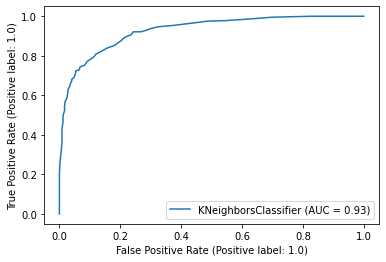

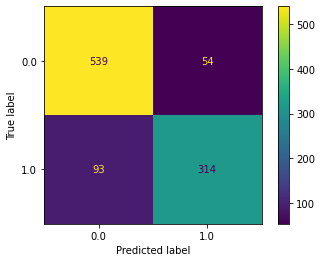

In [313]:
# STAND_TRANS: xtrain3 FULL
file_specific_pth = "images/STAND_TRAN/FULL/KNN/"

x_train_var = xtrain3
x_test_var = xtest3
x_valid_var = xvalid3

train_y = pd.DataFrame(y_train.reshape(-1,))

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))

knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 55,
                           weights = "uniform",
                           algorithm = 'auto')

knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

In [316]:
knc_explainer = shap.KernelExplainer(knc.predict, shap.sample(test_img, 10))
knc_shap_values = knc_explainer.shap_values(test_img)

100%|██████████| 1000/1000 [04:25<00:00,  3.76it/s]


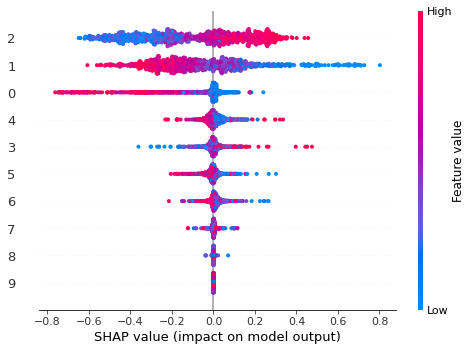

In [318]:
shap.summary_plot(knc_shap_values, test_img)

In [ ]:
# STAND_TRANS: xtrain3 REDUC
file_specific_pth = "images/STAND_TRAN/REDUC/KNN/"

x_train_var = x_train3[x_t3_lst]
x_test_var = x_test3[x_t3_lst]
x_valid_var = x_valid3[x_t3_lst]

pca = PCA(random_state = rand_state)
pca.fit(xtrain_var)

train_img = pd.DataFrame(pca.transform(xtrain_var))
test_img = pd.DataFrame(pca.transform(xtest_var))
valid_img = pd.DataFrame(pca.transform(xvalid_var))
knc = KNeighborsClassifier(leaf_size=35,
                           metric = "euclidean",
                           n_neighbors = 55,
                           weights = "uniform",
                           algorithm = 'auto')

knc.fit(train_img, train_y)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(knc, train_img, test_img, valid_img, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
    best_train_auc = train_auc
    b_tr_auc = outs
if test_auc > best_test_auc:
    best_test_auc = test_auc
    b_ts_auc = outs
if valid_auc > best_valid_auc:
    best_valid_auc = valid_auc
    b_v_auc = outs

if train_accuracy > best_train_accuracy:
    best_train_accuracy = train_accuracy
    b_tr_acc = outs
if test_accuracy > best_test_accuracy:
    best_test_accuracy = test_accuracy
    b_ts_acc = outs
if valid_accuracy > best_valid_accuracy:
    best_valid_accuracy = valid_accuracy
    b_v_acc = outs

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(knc, test_img, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ROC.png')

cm = confusion_matrix(y_test, knc.predict(test_img))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = knc.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'KNN_ConfuMatrix.png')

#### XGB

In [ ]:
# old work
# best_train_auc = 0
# best_test_auc = 0
# best_valid_auc = 0

# best_train_accuracy = 0
# best_test_accuracy = 0
# best_valid_accuracy = 0

# train_x = pd.DataFrame(xtrain2)
# test_x = pd.DataFrame(xtest2)
# valid_x = pd.DataFrame(xvalid2)

# train_y = pd.DataFrame(y_train)
# test_y = pd.DataFrame(y_test)
# valid_y = pd.DataFrame(y_valid)

# x1 = train_x[(train_y == 1).values]
# y1 = train_y[(train_y == 1).values]

# x, y = resample(x1, y1,
#                 replace = True,
#                 n_samples = (len(train_y) - 2*sum(train_y)),
#                 random_state = rand_state)

# xt = pd.concat([train_x, x])
# yt = pd.concat([train_y, y])

# xs, ys = shuffle(xt, yt, 
#                  random_state = rand_state)

# xgb = XGBClassifier(learning_rate = 0.10, 
#                 min_split_loss = 0,
#                 max_depth = 2,
#                 gamma = 0.5,
#                 min_child_weight = 1,
#                 max_delta_step = 0,
#                 subsample = 1,
#                 n_estimators = 400)

# eval_set = [(train_x, train_y), (valid_x, valid_y)]

# xgb.fit(xs, ys, 
#         eval_metric='auc', 
#         eval_set = eval_set)

# train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

# outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

# if train_auc > best_train_auc:
#         best_train_auc = train_auc
# if test_auc > best_test_auc:
#         best_test_auc = test_auc
# if valid_auc > best_valid_auc:
#         best_valid_auc = valid_auc
# if train_accuracy > best_train_accuracy:
#         best_train_accuracy = train_accuracy
# if test_accuracy > best_test_accuracy:
#         best_test_accuracy = test_accuracy
# if valid_accuracy > best_valid_accuracy:
#         best_valid_accuracy = valid_accuracy

# print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
# print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
# print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

# print("Best      Training AUC: ", best_train_auc, b_tr_acc)
# print("Best          Test AUC: ", best_test_auc, b_ts_acc)
# print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

In [ ]:
# explainer = shap.Explainer(xgb, xtrain2)
# shap_values = explainer(xtrain2)

# shap.plots.waterfall(shap_values[0])

# shap.plots.scatter(shap_values[:,"ACCREDAGENCY Encoded"])

# shap.plots.bar(shap_values)

# shap.plots.bar(shap_values[1])

# shap.plots.beeswarm(shap_values,
#                     order = shap_values.abs.max(0),
#                     color=plt.get_cmap("PuBu_r")
#                     )

In [ ]:
# explainer = shap.TreeExplainer(xgb)

# expected_value = explainer.expected_value

# if isinstance(expected_value, list):
#     expected_value = expected_value[1]
# print(f"Explainer expected value: {expected_value}")

# select = range(20)
# features = xtrain2.iloc[select]
# features_display = xtrain2.loc[features.index]

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     shap_values = explainer.shap_values(features)[1]
#     shap_interaction_values = explainer.shap_interaction_values(features)
    
# if isinstance(shap_interaction_values, list):
#     shap_interaction_values = shap_interaction_values[1]

# shap.decision_plot(expected_value, shap_values, xtrain2.columns.values)

In [ ]:
# shap.force_plot(expected_value, shap_values[misclassified], features_display[misclassified],
#                 link='logit', matplotlib=True)

In [ ]:
# y_pred = (shap_values.sum(1) + expected_value) > 0
# misclassified = y_pred != y_test[select]
# shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified)
# Our naive cutoff point is zero log odds (probability 0.5).

In [ ]:
# ORIG: xtrain FULL
file_specific_pth = "images/ORIG/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain)
test_x = pd.DataFrame(xtest)
valid_x = pd.DataFrame(xvalid)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                    max_depth = 2,
                    gamma = 0.5,
                    n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

In [ ]:
# ORIG: xtrain REDUC
file_specific_pth = "images/ORIG/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain[x_t1_lst])
test_x = pd.DataFrame(xtest[x_t1_lst])
valid_x = pd.DataFrame(xvalid[x_t1_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

In [ ]:
# ORIG: xtrain2 FULL
file_specific_pth = "images/ORIG/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain2)
test_x = pd.DataFrame(xtest2)
valid_x = pd.DataFrame(xvalid2)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

In [ ]:
# STAND: xtrain2 REDUC
file_specific_pth = "images/STAND/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(x_train2[x_t2_lst])
test_x = pd.DataFrame(x_test2[x_t2_lst])
valid_x = pd.DataFrame(x_valid2[x_t2_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 6,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

In [ ]:
# STAND_TRANS: xtrain3 FULL
file_specific_pth = "images/STAND_TRAN/FULL/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(xtrain3)
test_x = pd.DataFrame(xtest3)
valid_x = pd.DataFrame(xvalid3)

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.10, 
                max_depth = 2,
                gamma = 0.5,
                n_estimators = 400)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

In [ ]:
import shap

# shap.TreeExplainer

# build a Permutation explainer and explain the model predictions on the given dataset
# explainer = shap.explainers.GPUTree(xgb, xtrain3)
# shap_values = explainer(xtrain3)

# get just the explanations for the positive class
# shap_values = shap_values

In [ ]:
# STAND_TRANS: xtrain3 REDUC
file_specific_pth = "images/STAND_TRAN/REDUC/XGB/"

best_train_auc = 0
best_test_auc = 0
best_valid_auc = 0

best_train_accuracy = 0
best_test_accuracy = 0
best_valid_accuracy = 0

train_x = pd.DataFrame(x_train3[x_t3_lst])
test_x = pd.DataFrame(x_test3[x_t3_lst])
valid_x = pd.DataFrame(x_valid3[x_t3_lst])

train_y = pd.DataFrame(y_train)
test_y = pd.DataFrame(y_test)
valid_y = pd.DataFrame(y_valid)

x1 = train_x[(train_y == 1).values]
y1 = train_y[(train_y == 1).values]

x, y = resample(x1, y1,
                replace = True,
                n_samples = (len(train_y) - 2*sum(train_y)),
                random_state = rand_state)

xt = pd.concat([train_x, x])
yt = pd.concat([train_y, y])

xs, ys = shuffle(xt, yt, 
                 random_state = rand_state)

xgb = XGBClassifier(learning_rate = 0.70, 
                min_split_loss = 0,
                max_depth = 4,
                gamma = 0.01,
                min_child_weight = 1,
                max_delta_step = 0,
                subsample = 1,
                n_estimators = 1000)

eval_set = [(train_x, train_y), (valid_x, valid_y)]

xgb.fit(xs, ys, 
        eval_metric='auc', 
        eval_set = eval_set)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(xgb, test_x, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ROC.png')

cm = confusion_matrix(y_test, xgb.predict(test_x))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = xgb.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'XGB_ConfuMatrix.png')

In [ ]:
## OLD WORK


# xgblst = []
# # xg_mod = []

# best_train_auc = 0
# best_test_auc = 0
# best_valid_auc = 0

# best_train_accuracy = 0
# best_test_accuracy = 0
# best_valid_accuracy = 0

# lr = [0.001, 0.01, 0.1, 0.7]
# gg = [0, 0.001, 0.01]
# n_est = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# depth = [3,5,6,7,9]


# for learn in lr:
#     for nest in n_est:
#         for dep in depth:
#                 for g in gg:
#                         params = [learn, nest, dep]
#                         xgb = XGBClassifier(learning_rate = learn,
#                                         gamma = g, 
#                                         max_depth = dep,
#                                         min_child_weight = 1,
#                                         max_delta_step = 0,
#                                         subsample = nest,
#                                         n_estimators = 1000)
                        
#                         eval_set = [(train_x, train_y), (valid_x, valid_y)]
                        
#                         xgb.fit(xs, ys, 
#                                 eval_metric='auc', 
#                                 eval_set = eval_set)

#                         train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, train_x, test_x, valid_x, train_y, test_y, valid_y)

#                         if train_auc > best_train_auc:
#                                 best_train_auc = train_auc
#                         if test_auc > best_test_auc:
#                                 best_test_auc = test_auc
#                         if valid_auc > best_valid_auc:
#                                 best_valid_auc = valid_auc
#                         if train_accuracy > best_train_accuracy:
#                                 best_train_accuracy = train_accuracy
#                         if test_accuracy > best_test_accuracy:
#                                 best_test_accuracy = test_accuracy
#                         if valid_accuracy > best_valid_accuracy:
#                                 best_valid_accuracy = valid_accuracy

#                         cm = confusion_matrix(y_test, xgb.predict(test_x))

#                         xgblst.append([learn, nest, dep, g,
#                                 train_auc, test_auc, valid_auc,
#                                 train_accuracy, test_accuracy, valid_accuracy,
#                                 cm[0,0], cm[0,1], cm[1,0], cm[1,1]]) 



# xgblst_outcomes.sort_values("Test_AUC", ascending = False)
# xgblst_outcomes["AUC_traintest_diff"] = xgblst_outcomes["Test_AUC"] - xgblst_outcomes["Train_AUC"]
# xgblst_outcomes["ABS_AUC_traintest_diff"] = abs(xgblst_outcomes["Test_AUC"] - xgblst_outcomes["Train_AUC"])
# xgblst_outcomes["max_acc_ratio"] = round(((xgblst_outcomes["Test_Accurcy"] / xgblst_outcomes["Test_Accurcy"].max()) - 1) * 100, 2)

# xgblst_outcomes.query("Train_AUC < Test_AUC").sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
# xgblst_outcomes.sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
# xgblst_outcomes.sort_values("Test_Accurcy", ascending=False).head(5)

# learning_rate	n_est	dep	Train_AUC	Test_AUC	Valid_AUC	Train_Accurcy	Test_Accurcy	Valid_Accurcy	AUC_traintest_diff	ABS_AUC_traintest_diff	max_acc_ratio           
# 0.30	        10	    4	0.9819	    0.9621	    0.9652	    0.9075	        0.885	        0.887	        -0.0198	            0.0198	                -3.49           
# 0.01	        500	    3	0.9815	    0.9667	    0.9671	    0.9028	        0.885	        0.877	        -0.0148	            0.0148	                -3.49           
# 0.10	        10	    3	0.9584	    0.9532  	0.9522  	0.8721	        0.854       	0.871   	    -0.0052	            0.0052               	-6.87           
# 0.01	        100 	3	0.9591  	0.9527	    0.9519	    0.8708      	0.860	        0.866       	-0.0064	            0.0064  	            -6.22           
# 0.01	        10  	3	0.9293  	0.9195  	0.9261  	0.8564      	0.846	        0.857       	-0.0098	            0.0098	                -7.74    

In [ ]:
# colums = ["learning_rate", "n_est", "dep", "gamma",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           "TP", "FP", "FN", "TN"
#           ]
# xgblst_outcomes = pd.DataFrame(xgblst, columns = colums)

# print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
# print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
# print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

# print("Best      Training AUC: ", best_train_auc, b_tr_acc)
# print("Best          Test AUC: ", best_test_auc, b_ts_acc)
# print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

# xgblst_outcomes["T"] = xgblst_outcomes["TP"] + xgblst_outcomes["TN"]
# xgblst_outcomes["F"] = xgblst_outcomes["FP"] + xgblst_outcomes["FN"]
# xgblst_outcomes["T / F"] = xgblst_outcomes["T"] / xgblst_outcomes["F"]
# xgblst_outcomes.sort_values("T / F", ascending = False).head(15)

#### XGBoost with PCA

In [ ]:
# xgb_lst_pca = []

# best_train_auc = 0
# best_test_auc = 0
# best_valid_auc = 0

# best_train_accuracy = 0
# best_test_accuracy = 0
# best_valid_accuracy = 0

# n_est = [100]
# depth = [5, 7]
# gams = [10]
# lr = [0.001]
# lef = [100]
# alph = [0.2]
# n_comp = np.array(range(1,xtrain3.shape[1]-1,2)) # [5, 7, 9] # 

# for nc in n_comp:
#     for learn in lr:
#         for nest in n_est:
#                 for dep in depth:
#                     for g in gams:
#                         for l in lef:
#                             for a in alph:
#                                 params = [nc, learn, nest, dep, g, l, a]

#                                 pca = PCA(n_components = nc)
#                                 pca.fit(xtrain3)

#                                 train_img = pd.DataFrame(pca.transform(xtrain3))
#                                 test_img = pd.DataFrame(pca.transform(xtest3))
#                                 valid_img = pd.DataFrame(pca.transform(xvalid3))

#                                 x1 = train_img[(train_y == 1).values.reshape(-1,)]
#                                 y1 = train_y[(train_y == 1).values.reshape(-1,)]

#                                 x, y = resample(x1, y1,
#                                                 replace = True,
#                                                 n_samples = (len(train_y) - 2*sum(train_y)),
#                                                 random_state = rand_state)

#                                 xt = pd.concat([train_img, x])
#                                 yt = pd.concat([train_y, y])

#                                 xs, ys = shuffle(xt, yt, 
#                                                 random_state = rand_state)

#                                 xgb = XGBClassifier(learning_rate = learn, 
#                                                     gamma = g, # range [0, INF] a higher value means more conservative alg
#                                                     max_depth = dep, # range [0, INF] a higher value means less conservative alg
#                                                     min_child_weight = l, # range [0, INF] a higher value means more conservative alg
#                                                     n_estimators = nest,
#                                                     alpha = a,
#                                                     random_state = rand_state)
                                
#                                 eval_set = [(train_img, train_y), (valid_img, valid_y)]
                                
#                                 xgb.fit(xs, ys, 
#                                         eval_metric='auc', 
#                                         eval_set = eval_set)
                                
#                                 train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(xgb, xs, test_img, valid_img, ys, y_test, y_valid)

#                                 outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

#                                 if train_auc > best_train_auc:
#                                     best_train_auc = train_auc
#                                     b_tr_auc = outs
#                                 if test_auc > best_test_auc:
#                                     best_test_auc = test_auc
#                                     b_ts_auc = outs
#                                 if valid_auc > best_valid_auc:
#                                     best_valid_auc = valid_auc
#                                     b_v_auc = outs

#                                 if train_accuracy > best_train_accuracy:
#                                     best_train_accuracy = train_accuracy
#                                     b_tr_acc = outs
#                                 if test_accuracy > best_test_accuracy:
#                                     best_test_accuracy = test_accuracy
#                                     b_ts_acc = outs
#                                 if valid_accuracy > best_valid_accuracy:
#                                     best_valid_accuracy = valid_accuracy
#                                     b_v_acc = outs

#                                 xgb_lst_pca.append([nc, learn, dep, g, nest, l, a,
#                                                     train_auc, test_auc, valid_auc,
#                                                     train_accuracy, test_accuracy, valid_accuracy]) 

# colums = ["n_comp", "learning_rate", "max_depth", "gamma", "max_iter", "leaf", "alpha",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           ]
# xgb_pca_outcomes = pd.DataFrame(xgb_lst_pca, columns = colums)

# colums = ["n_comp", "learning_rate", "max_depth", "gamma", "max_iter", "leaf", "alpha",
#           "Train_AUC", "Test_AUC", "Valid_AUC",
#           "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy",
#           ]
# xgb_pca_outcomes = pd.DataFrame(xgb_lst_pca, columns = colums)

# print("Best Training Accuracy: ", best_train_accuracy, b_tr_auc)
# print("Best     Test Accuracy: ", best_test_accuracy, b_ts_auc)
# print("Best    Valid Accuracy: ", best_valid_accuracy, b_v_auc)

# print("Best      Training AUC: ", best_train_auc, b_tr_acc)
# print("Best          Test AUC: ", best_test_auc, b_ts_acc)
# print("Best         Valid AUC: ", best_valid_auc, b_v_acc)

# xgb_pca_outcomes.sort_values("Test_AUC", ascending = False)
# xgb_pca_outcomes["AUC_traintest_diff"] = xgb_pca_outcomes["Test_AUC"] - xgb_pca_outcomes["Train_AUC"]
# xgb_pca_outcomes["ABS_AUC_traintest_diff"] = abs(xgb_pca_outcomes["Test_AUC"] - xgb_pca_outcomes["Train_AUC"])
# xgb_pca_outcomes["ABS_Accurcy_traintest_diff"] = abs(xgb_pca_outcomes["Test_Accurcy"] - xgb_pca_outcomes["Train_Accurcy"])
# xgb_pca_outcomes["max_acc_ratio%"] = round(((xgb_pca_outcomes["Test_Accurcy"] / xgb_pca_outcomes["Test_Accurcy"].max()) - 1) * 100, 2)

# xgb_pca_outcomes.sort_values("ABS_Accurcy_traintest_diff", ascending=True).head(15)
# xgb_pca_outcomes.query("Train_AUC < 1").sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
# xgb_pca_outcomes.sort_values("Test_Accurcy", ascending=False).head(5)

#### Random Forest

In [ ]:
# RFC_lst = []

# best_train_auc = 0
# best_test_auc = 0
# best_valid_auc = 0

# best_train_accuracy = 0
# best_test_accuracy = 0
# best_valid_accuracy = 0

# crit = ["gini", "entropy"]
# depth = [10]
# lef = np.array()
# n_est = [1000]

# for c in crit:
#         for n in n_est:
#                 for d in depth:
#                         for l in lef:
#                                 params = [c, n, d, l]
#                                 Random_forest = RandomForestClassifier(n_estimators = n, #  The number of trees in the forest.
#                                                                         criterion = c,
#                                                                         max_depth = d,  
#                                                                         min_samples_leaf = l,
#                                                                         class_weight = 'balanced_subsample',
#                                                                         random_state = rand_state)
#                                 Random_forest.fit(xtrain, y_train)

#                                 train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain, xtest, xvalid, y_train, y_test, y_valid)

#                                 outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

#                                 if train_auc > best_train_auc:
#                                         best_train_auc = train_auc
#                                         b_tr_auc = outs
#                                 if test_auc > best_test_auc:
#                                         best_test_auc = test_auc
#                                         b_ts_auc = outs
#                                 if valid_auc > best_valid_auc:
#                                         best_valid_auc = valid_auc
#                                         b_v_auc = outs

#                                 if train_accuracy > best_train_accuracy:
#                                         best_train_accuracy = train_accuracy
#                                         b_tr_acc = outs
#                                 if test_accuracy > best_test_accuracy:
#                                         best_test_accuracy = test_accuracy
#                                         b_ts_acc = outs
#                                 if valid_accuracy > best_valid_accuracy:
#                                         best_valid_accuracy = valid_accuracy
#                                         b_v_acc = outs

#                                 RFC_lst.append([c, n, d, l,
#                                                 train_auc, test_auc, valid_auc,
#                                                 train_accuracy, test_accuracy, valid_accuracy]) 

# colums = ["criterion", "n_est", "max_depth", "leaf", "Train_AUC", "Test_AUC", "Valid_AUC", "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy"]

# rand_forest_outcomes = pd.DataFrame(RFC_lst, columns = colums)

# rand_forest_outcomes["AUC_traintest_diff"] = rand_forest_outcomes["Test_AUC"] - rand_forest_outcomes["Train_AUC"]
# rand_forest_outcomes["ABS_AUC_traintest_diff"] = abs(rand_forest_outcomes["Test_AUC"] - rand_forest_outcomes["Train_AUC"])
# rand_forest_outcomes["max_acc_ratio"] = round(((rand_forest_outcomes["Test_Accurcy"] / rand_forest_outcomes["Test_Accurcy"].max()) - 1) * 100, 2)

# rand_forest_outcomes.query("AUC_traintest_diff > 0").sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
# rand_forest_outcomes.sort_values("ABS_AUC_traintest_diff", ascending=True).head(15)
# # rand_forest_outcomes.sort_values("Test_Accurcy", ascending=False).head(15)

In [ ]:
# ORIG: xtrain FULL
file_specific_pth = "images/ORIG/FULL/RanFor/"

xtrain_var = xtrain
xtest_var = xtest
xvalid_var = xvalid

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

In [ ]:
# ORIG: xtrain REDUC
file_specific_pth = "images/ORIG/REDUC/RanFor/"

xtrain_var = xtrain[x_t1_lst]
xtest_var = xtest[x_t1_lst]
xvalid_var = xvalid[x_t1_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

In [ ]:
# STAND: xtrain2 FULL
file_specific_pth = "images/STAND/FULL/RanFor/"

xtrain_var = xtrain2
xtest_var = xtest2
xvalid_var = xvalid2

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

In [ ]:
# STAND: xtrain2 REDUC
file_specific_pth = "images/STAND/REDUC/RanFor/"

xtrain_var = xtrain2[x_t2_lst]
xtest_var = xtest2[x_t2_lst]
xvalid_var = xvalid2[x_t2_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

In [ ]:
sorted_idx = Random_forest.feature_importances_.argsort()
plt.barh(xtrain_var.columns.values[sorted_idx], Random_forest.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_featimport.png')

In [ ]:
class_name = ["Majority Pell institution", "Minority Pell institution"]

explainer = shap.TreeExplainer(Random_forest)
shap_values = explainer.shap_values(xtest_var)
shap.summary_plot(shap_values[0], xtest_var, class_names = class_name, feature_names = xtest_var.columns.values)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_beeswarm.png')

In [ ]:
# STAND_TRANS: xtrain3 FULL
file_specific_pth = "images/STAND_TRAN/FULL/RanFor/"

xtrain_var = xtrain3
xtest_var = xtest3
xvalid_var = xvalid3

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')

In [ ]:
# STAND_TRANS: xtrain3 REDUC
file_specific_pth = "images/STAND_TRAN/REDUC/RanFor/"

xtrain_var = xtrain3[x_t3_lst]
xtest_var = xtest3[x_t3_lst]
xvalid_var = xvalid3[x_t3_lst]

Random_forest = RandomForestClassifier(n_estimators = 700, #  The number of trees in the forest.
                                       criterion = "entropy",
                                       max_depth = 6,  
                                       min_samples_leaf = 6,
                                       class_weight = 'balanced_subsample',
                                       random_state = rand_state)
Random_forest.fit(xtrain_var, y_train)

train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, xtrain_var, xtest_var, xvalid_var, y_train, y_test, y_valid)

outs = [train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

if train_auc > best_train_auc:
        best_train_auc = train_auc
if test_auc > best_test_auc:
        best_test_auc = test_auc
if valid_auc > best_valid_auc:
        best_valid_auc = valid_auc
if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy

print("Best Training Accuracy: ", best_train_accuracy)
print("Best     Test Accuracy: ", best_test_accuracy)
print("Best    Valid Accuracy: ", best_valid_accuracy)

print("Best      Training AUC: ", best_train_auc)
print("Best          Test AUC: ", best_test_auc)
print("Best         Valid AUC: ", best_valid_auc)

metrics.plot_roc_curve(Random_forest, xtest_var, y_test)
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ROC.png')

cm = confusion_matrix(y_test, Random_forest.predict(xtest_var))
ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = Random_forest.classes_).plot()
plt.savefig(my_filesys_pth + file_specific_pth + 'RF_ConfuMatrix.png')


#### Random Forest with PCA

In [ ]:
# RFC_lst = []


# best_train_auc = 0
# best_test_auc = 0
# best_valid_auc = 0

# best_train_accuracy = 0
# best_test_accuracy = 0
# best_valid_accuracy = 0

# crit = ["gini", "entropy"]
# depth = [6]
# lef = [6] # ,6,7,8,9,10,20,50,100
# n_est = [700]
# n_comp = [1]

# for nc in n_comp:
#         for c in crit:
#                 for n in n_est:
#                         for d in depth:
#                                 for l in lef:
#                                         params = [nc, c, n, d, l]

#                                         # pca = PCA(n_components = nc)
#                                         # pca.fit(xtrain2)

#                                         # train_img = pca.transform(xtrain2)
#                                         # test_img = pca.transform(xtest2)
#                                         # valid_img = pca.transform(xvalid2)

#                                         train_img = xtrain2
#                                         test_img = xtest2
#                                         valid_img = xvalid2

#                                         Random_forest = RandomForestClassifier(n_estimators = n, #  The number of trees in the forest.
#                                                                                 criterion = c,
#                                                                                 max_depth = d,  
#                                                                                 min_samples_leaf = l,
#                                                                                 class_weight = 'balanced_subsample',
#                                                                                 random_state = rand_state)
#                                         Random_forest.fit(xtrain, y_train)

#                                         train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy = get_outs(Random_forest, train_img, test_img, valid_img, y_train, y_test, y_valid)

#                                         outs = [params, train_auc, test_auc, valid_auc, train_accuracy, test_accuracy, valid_accuracy]

#                                         if train_auc > best_train_auc:
#                                                 best_train_auc = train_auc
#                                                 b_tr_auc = outs
#                                         if test_auc > best_test_auc:
#                                                 best_test_auc = test_auc
#                                                 b_ts_auc = outs
#                                         if valid_auc > best_valid_auc:
#                                                 best_valid_auc = valid_auc
#                                                 b_v_auc = outs

#                                         if train_accuracy > best_train_accuracy:
#                                                 best_train_accuracy = train_accuracy
#                                                 b_tr_acc = outs
#                                         if test_accuracy > best_test_accuracy:
#                                                 best_test_accuracy = test_accuracy
#                                                 b_ts_acc = outs
#                                         if valid_accuracy > best_valid_accuracy:
#                                                 best_valid_accuracy = valid_accuracy
#                                                 b_v_acc = outs

#                                         cm = confusion_matrix(y_test, Random_forest.predict(test_img))

#                                         RFC_lst.append([nc, c, n, d, l,
#                                                         train_auc, test_auc, valid_auc,
#                                                         train_accuracy, test_accuracy, valid_accuracy, 
#                                                         cm[0,0], cm[0,1], cm[1,0], cm[1,1]]) 

# rand_forest_outcomes = pd.DataFrame(RFC_lst, columns = ["n_comp", "criterion", "n_est", "max_depth", "leaf", "Train_AUC", "Train_Accurcy", "Test_AUC", "Test_Accurcy", "Valid_AUC", "Valid_Accurcy"])
# rand_forest_outcomes

# n_comp	criterion	n_est	max_depth	leaf	Train_AUC	Test_AUC	Valid_AUC	Train_Accurcy	Test_Accurcy	Valid_Accurcy	AUC_traintest_diff	ABS_AUC_traintest_diff	max_acc_ratio	testtrain_acc_ratio
# 39	3	gini	1000	6	20	0.8700	0.8588	0.8568	0.7783	0.779	0.776	-0.0112	0.0112	7.1514	1.0009
# 34	3	gini	1000	3	15	0.8283	0.8338	0.8277	0.7517	0.759	0.750	0.0055	0.0055	9.5352	1.0097
# 35	3	gini	1000	3	20	0.8281	0.8334	0.8273	0.7520	0.759	0.750	0.0053	0.0053	9.5352	1.0093
# 48	3	entropy	1000	3	5	0.8291	0.8349	0.8295	0.7530	0.759	0.750	0.0058	0.0058	9.5352	1.0080
# 32	3	gini	1000	3	5	0.8284	0.8346	0.8276	0.7533	0.758	0.750	0.0062	0.0062	9.6544	1.0062

In [ ]:
# colums = ["n_comp", "criterion", "n_est", "max_depth", "leaf", "Train_AUC", "Test_AUC", "Valid_AUC", "Train_Accurcy", "Test_Accurcy", "Valid_Accurcy", "TP", "FP", "FN", "TN"]
# rand_forest_outcomes = pd.DataFrame(RFC_lst, columns = colums)
# rand_forest_outcomes["T"] = rand_forest_outcomes["TP"] + rand_forest_outcomes["TN"]
# rand_forest_outcomes["F"] = rand_forest_outcomes["FP"] + rand_forest_outcomes["FN"]
# rand_forest_outcomes["T / F"] = rand_forest_outcomes["T"] / rand_forest_outcomes["F"]

# rand_forest_outcomes.sort_values("T / F", ascending = False).head(15) #.groupby("leaf").count()

In [ ]:
# sns.scatterplot(x = rand_forest_outcomes["Train_Accurcy"], y = rand_forest_outcomes["T / F"])

# sns.scatterplot(x = rand_forest_outcomes["Test_Accurcy"], y = rand_forest_outcomes["T / F"])

# sns.scatterplot(x = rand_forest_outcomes["Test_AUC"], y = rand_forest_outcomes["T / F"])

# sns.scatterplot(x = rand_forest_outcomes["Valid_Accurcy"], y = rand_forest_outcomes["T / F"])

# sns.scatterplot(x = rand_forest_outcomes["Valid_AUC"], y = rand_forest_outcomes["T / F"])